<a href="https://colab.research.google.com/github/Okocha76/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS10_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

## Precooked

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

## Explore & clean the data

In [0]:
import numpy as np

In [0]:
!pip install -U pandas-profiling

In [9]:
df.head()

Burrito       Date  Yelp  Google Chips  ...  Sushi  Avocado  Corn  Zucchini  Great
0  California  1/18/2016   3.5     4.2   NaN  ...    NaN      NaN   NaN       NaN  False
1  California  1/24/2016   3.5     3.3   NaN  ...    NaN      NaN   NaN       NaN  False
2    Carnitas  1/24/2016   NaN     NaN   NaN  ...    NaN      NaN   NaN       NaN  False
3       Asada  1/24/2016   NaN     NaN   NaN  ...    NaN      NaN   NaN       NaN  False
4  California  1/27/2016   4.0     3.8     x  ...    NaN      NaN   NaN       NaN   True

[5 rows x 59 columns]

In [10]:
df.describe().T

count        mean  ...         75%         max
Yelp             87.0    3.887356  ...    4.000000    4.500000
Google           87.0    4.167816  ...    4.400000    5.000000
Cost            414.0    7.067343  ...    7.880000   25.000000
Hunger          418.0    3.495335  ...    4.000000    5.000000
Mass (g)         22.0  546.181818  ...  595.000000  925.000000
Density (g/mL)   22.0    0.675277  ...    0.721726    0.865672
Length          283.0   20.038233  ...   21.500000   26.000000
Circum          281.0   22.135765  ...   23.000000   29.000000
Volume          281.0    0.786477  ...    0.880000    1.540000
Tortilla        421.0    3.519477  ...    4.000000    5.000000
Temp            401.0    3.783042  ...    4.500000    5.000000
Meat            407.0    3.620393  ...    4.000000    5.000000
Fillings        418.0    3.539833  ...    4.000000    5.000000
Meat:filling    412.0    3.586481  ...    4.000000    5.000000
Uniformity      419.0    3.428998  ...    4.000000    5.000000
Salsa           396.0    3.371970  ...    4.000000    5.000000
Synergy         419.0    3.586993  ...    4.000000    5.000000
Wrap            418.0    3.979904  ...    5.000000    5.000000
Queso             0.0         NaN  ...         NaN         NaN

[19 rows x 8 columns]

In [0]:
# df['Chips'] = df['Chips'].replace('Yes','x')
df['Chips'] = df['Chips'].replace('No',np.nan)

In [0]:
ingredients = ['Chips','Unreliable','NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
               'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
                'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
                'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
                'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster',
                'Queso', 'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado',
                'Corn', 'Zucchini',]

for ingredient in ingredients:
    df[ingredient].replace('X','x')
    # df[ingredient].str.lower()

In [33]:
df.describe(exclude='number').T

count unique                  top freq      first       last
Burrito         421      5           California  169        NaT        NaT
Date            421    169  2016-08-30 00:00:00   29 2011-05-16 2019-08-27
Chips            25      2                    x   22        NaT        NaT
Unreliable       33      1                    x   33        NaT        NaT
NonSD             7      2                    x    5        NaT        NaT
Beef            179      2                    x  137        NaT        NaT
Pico            158      2                    x  127        NaT        NaT
Guac            154      2                    x  114        NaT        NaT
Cheese          159      2                    x  128        NaT        NaT
Fries           127      2                    x  102        NaT        NaT
Sour cream       92      2                    x   67        NaT        NaT
Pork             51      2                    x   36        NaT        NaT
Chicken          21      2                    x   20        NaT        NaT
Shrimp           21      2                    x   17        NaT        NaT
Fish              6      2                    x    4        NaT        NaT
Rice             36      2                    x   26        NaT        NaT
Beans            35      2                    x   27        NaT        NaT
Lettuce          11      2                    x    9        NaT        NaT
Tomato            7      2                    x    5        NaT        NaT
Bell peper        7      2                    x    4        NaT        NaT
Carrots           1      1                    x    1        NaT        NaT
Cabbage           8      2                    x    6        NaT        NaT
Sauce            38      2                    x   33        NaT        NaT
Salsa.1           7      2                    x    6        NaT        NaT
Cilantro         15      2                    x    9        NaT        NaT
Onion            17      2                    x    9        NaT        NaT
Taquito           4      2                    x    3        NaT        NaT
Pineapple         7      2                    x    5        NaT        NaT
Ham               2      1                    x    2        NaT        NaT
Chile relleno     4      1                    x    4        NaT        NaT
Nopales           4      1                    x    4        NaT        NaT
Lobster           1      1                    x    1        NaT        NaT
Egg               5      1                    x    5        NaT        NaT
Mushroom          3      1                    x    3        NaT        NaT
Bacon             3      1                    x    3        NaT        NaT
Sushi             2      1                    x    2        NaT        NaT
Avocado          13      1                    x   13        NaT        NaT
Corn              3      2                    x    2        NaT        NaT
Zucchini          1      1                    x    1        NaT        NaT
Great           421      2                False  239        NaT        NaT

In [14]:
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [15]:
import pandas_profiling

df.profile_report()

## Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
# Correct typo
df['Date'] = df['Date'].str.replace('2026','2016')

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [0]:
cutoff1 = pd.to_datetime('2017-01-01')
cutoff2 = pd.to_datetime('2018-01-01')

train = df[df.Date < cutoff1]
val = df[((df.Date >= cutoff1) & (df.Date < cutoff2))]
test  = df[df.Date >= cutoff2]

In [18]:
train.shape, val.shape

((299, 59), (85, 59))

## Begin with baselines for classification.

In [19]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.588629
True     0.411371
Name: Great, dtype: float64

In [20]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5886287625418061

In [21]:
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

## Use scikit-learn for logistic regression.

In [0]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')

In [0]:
features = ['Fillings','Meat','Salsa']
X_train = train[features]
X_val = val[features]
y_val = val[target]

In [56]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((299, 3), (299,), (85, 3), (85,))

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [58]:
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.8823529411764706


In [59]:
train['Salsa'].describe()

count    279.000000
mean       3.323477
std        0.969673
min        0.000000
25%        2.500000
50%        3.500000
75%        4.000000
max        5.000000
Name: Salsa, dtype: float64

In [60]:
test_case1 = [[2, 2, 2]] 

log_reg.predict_proba(test_case1)

array([[0.99853219, 0.00146781]])

In [61]:
test_case2 = [[4, 4, 4]] 

log_reg.predict_proba(test_case2)

array([[0.25932389, 0.74067611]])

## Get your model's validation accuracy. 

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
features = ['Fillings','Meat','Salsa']
  # ,'Meat:filling','Uniformity','Tortilla','Synergy','Temp','Burrito']
target = 'Great'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [141]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((299, 3), (299,), (85, 3), (85,))

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [143]:
model = LogisticRegressionCV(cv=5, n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8823529411764706


Plot coefficients:

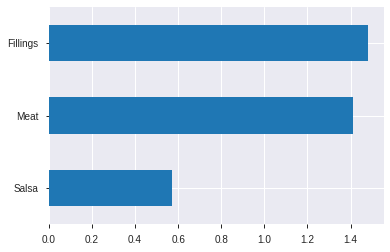

In [144]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();